Columns detected: ['GLADE_no', 'PGC_no', 'GWGC_name', 'HyperLEDA_name', '2MASS_name', 'WISExSCOS_name', 'SDSS_DR16Q_name', 'ObjTypeFlag', 'RA', 'Dec', 'B', 'B_err', 'B_flag', 'B_Abs', 'J', 'J_err', 'H', 'H_err', 'K', 'K_err', 'W1', 'W1_err', 'W2', 'W2_err', 'W1_flag', 'B_J', 'B_J_err', 'z_helio', 'z_cmb', 'z_flag', 'v_err', 'z_err', 'd_L', 'dL_err', 'dist_flag', 'Mstar', 'Mstar_err', 'Mstar_flag', 'MergerRate', 'MergerRateErr']


/tmp/ipykernel_23440/1295235546.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after cz>1200 km/s and d_L<100 Mpc: 442643
Number of galaxies: 442643
           GLADE_no             RA            Dec              B  \
count  4.426430e+05  442643.000000  442643.000000  434870.000000   
mean   7.424965e+06     186.524894       0.753835      17.401478   
std    7.396593e+06     101.413553      37.208011       1.501702   
min    2.000000e+00       0.001113     -89.874535       8.599506   
25%    1.164250e+06     102.837756     -27.388443      16.340000   
50%    3.177932e+06     192.897619       2.146690      17.680821   
75%    1.504873e+07     275.435680      28.558864      18.664633   
max    2.315124e+07     359.996490      89.649361      25.370000   

               B_Abs              J              H              K  \
count  434870.000000  143879.000000  143527.000000  144017.000000   
mean      -18.126880      13.497210      12.766679      12.443390   
std         1.582002       1.136777       1.158174       1.132563   
min       -23.879300  

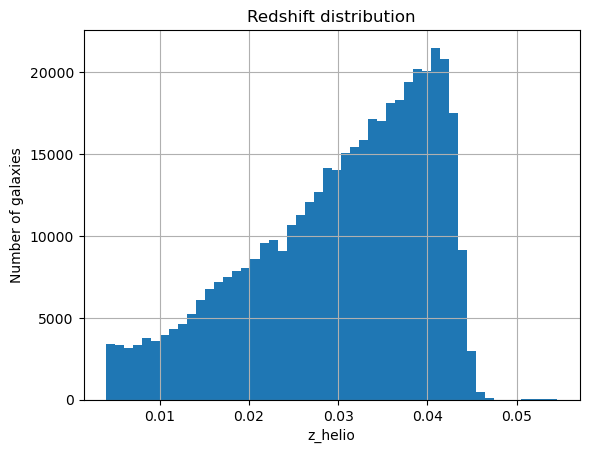

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
c = 299792.458  # km/s
chunksize = 200_000  # adjust based on RAM

# Columns we want to load
cols_to_use = [
    "GLADE_no","RA","Dec","z_helio","z_cmb","d_L",
    "B","J","H","K","B_Abs","Mstar","MergerRate"
]

# ----------------------------
# READ HEADER
# ----------------------------
with open(filename, 'r') as f:
    header = f.readline().lstrip('#').split()
print("Columns detected:", header)

# ----------------------------
# PROCESS IN CHUNKS
# ----------------------------
cz_min = 1200  # km/s
dL_max = 200   # Mpc

filtered_chunks = []

for chunk in pd.read_csv(
    filename,
    delim_whitespace=True,
    names=header,   # use header from file
    usecols=cols_to_use,
    skiprows=1,     # skip original header line
    chunksize=chunksize
):
    # Compute cz
    chunk["cz"] = c * chunk["z_helio"]

    # Apply both filters
    chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]

    filtered_chunks.append(chunk)

# Concatenate filtered chunks
df = pd.concat(filtered_chunks, ignore_index=True)

print(f"Remaining galaxies after cz>1200 km/s and d_L<100 Mpc: {len(df)}")



# ----------------------------
# INSPECT DATA
# ----------------------------
print("Number of galaxies:", len(df))
print(df.describe())

# ----------------------------
# BASIC PLOTS
# ----------------------------
# Redshift distribution
plt.figure()
df['z_helio'].hist(bins=50)
plt.xlabel("z_helio")
plt.ylabel("Number of galaxies")
plt.title("Redshift distribution")
plt.show()

# # Stellar mass distribution
# plt.figure()
# df['Mstar'].hist(bins=50)
# plt.xlabel("Stellar mass [Msun]")
# plt.ylabel("Number of galaxies")
# plt.title("Stellar mass distribution")
# plt.show()

# # Sky plot (RA, Dec)
# plt.figure(figsize=(8,4))
# plt.scatter(df['RA'], df['Dec'], s=1, alpha=0.5)
# plt.xlabel("RA [deg]")
# plt.ylabel("Dec [deg]")
# plt.title("Galaxy positions")
# plt.show()


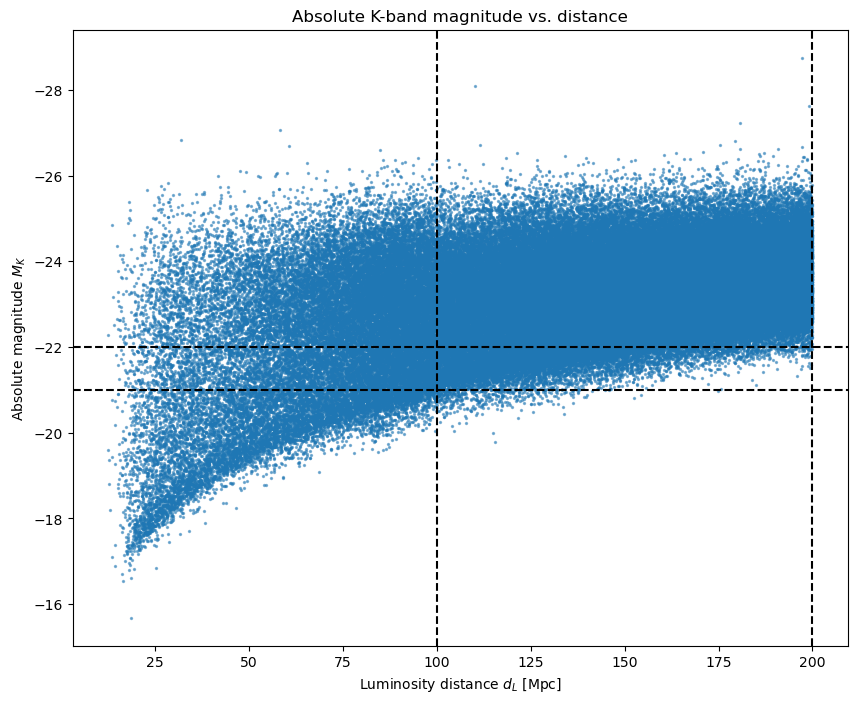

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute K magnitude
df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

# Plot
plt.figure(figsize=(10,8))
plt.scatter(df["d_L"], df["M_K"], s=2, alpha=0.5)
# Vertical lines
plt.axvline(x=100, color='k', linestyle='dashed')
plt.axvline(x=200, color='k', linestyle='dashed')
# Horizontal lines
plt.axhline(-21, color='k', linestyle='dashed')
plt.axhline(-22, color='k', linestyle='dashed')

plt.xlabel("Luminosity distance $d_L$ [Mpc]")
plt.ylabel("Absolute magnitude $M_K$")
plt.title("Absolute K-band magnitude vs. distance")
plt.gca().invert_yaxis()  # brighter = up
plt.show()


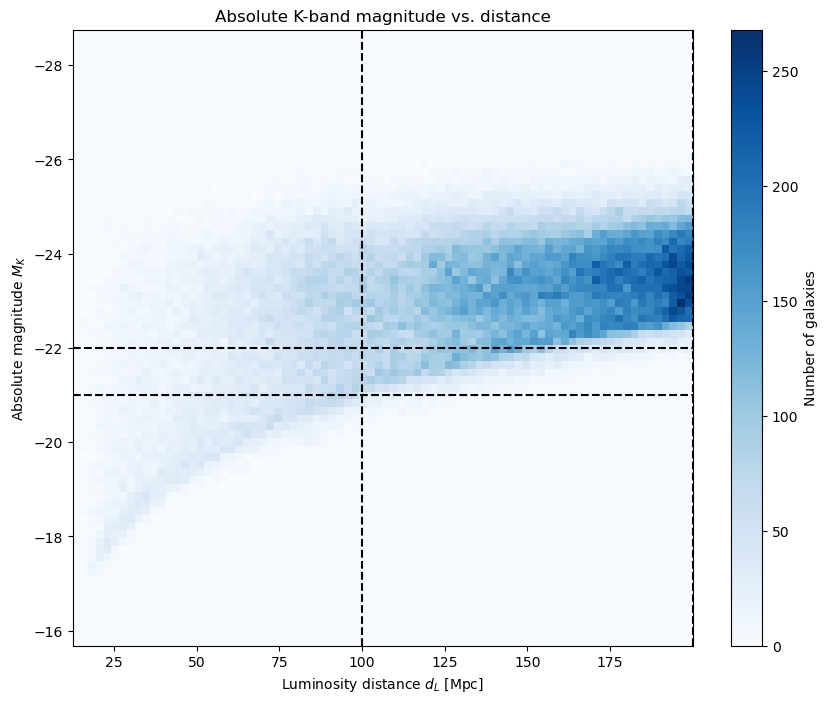

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute K magnitude
df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

# Remove NaNs
mask = (~df["K"].isna()) & (~df["d_L"].isna())
x = df.loc[mask, "d_L"]
y = df.loc[mask, "M_K"]

# Plot
plt.figure(figsize=(10,8))
plt.hist2d(x, y, bins=80, cmap='Blues')

# Vertical lines
plt.axvline(x=100, color='k', linestyle='dashed')
plt.axvline(x=200, color='k', linestyle='dashed')

# Horizontal lines
plt.axhline(-21, color='k', linestyle='dashed')
plt.axhline(-22, color='k', linestyle='dashed')

plt.xlabel("Luminosity distance $d_L$ [Mpc]")
plt.ylabel("Absolute magnitude $M_K$")
plt.title("Absolute K-band magnitude vs. distance")
plt.gca().invert_yaxis()  # brighter = up
plt.colorbar(label='Number of galaxies')
plt.show()


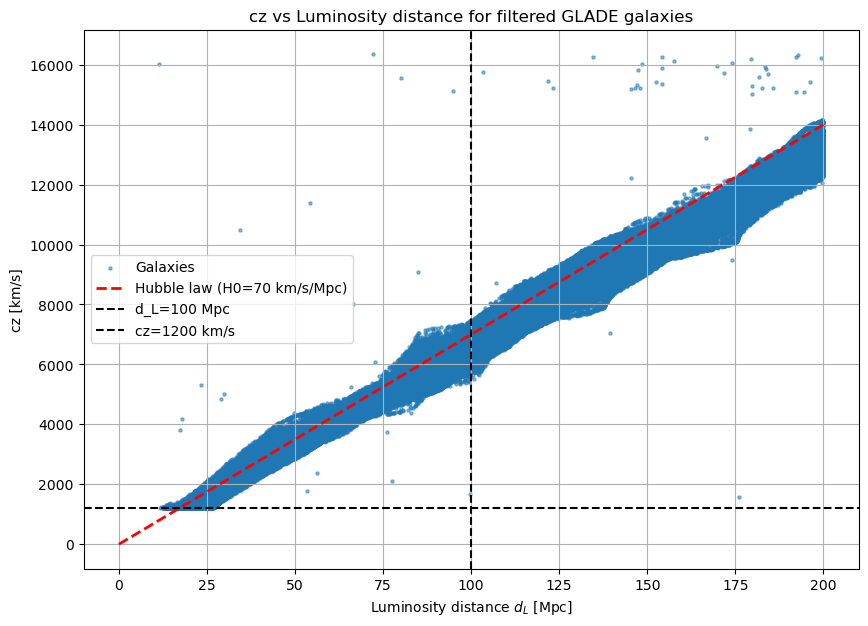

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure cz exists
c = 299792.458  # km/s
if "cz" not in df.columns:
    df["cz"] = c * df["z_helio"]

# Scatter plot
plt.figure(figsize=(10,7))
plt.scatter(df["d_L"], df["cz"], s=5, alpha=0.5, label="Galaxies")

# Hubble law line
H0 = 70  # km/s/Mpc
d = np.linspace(0, df["d_L"].max(), 200)
plt.plot(d, H0*d, 'r--', linewidth=2, label=f"Hubble law (H0={H0} km/s/Mpc)")

# Selection cut lines
plt.axvline(x=100, color='k', linestyle='dashed', label="d_L=100 Mpc")
plt.axhline(y=1200, color='k', linestyle='dashed', label="cz=1200 km/s")

plt.xlabel("Luminosity distance $d_L$ [Mpc]")
plt.ylabel("cz [km/s]")
plt.title("cz vs Luminosity distance for filtered GLADE galaxies")
plt.grid(True)
plt.legend()
plt.show()
